In [50]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import random as rnd
import scipy.io

from sklearn import preprocessing
from sklearn.svm import SVC, LinearSVC

%matplotlib inline

## 3.2 Loading Data and Displaying Faceboard

In [51]:
# load the input data

YALE = scipy.io.loadmat('YALEBXF.mat')
X = YALE['X']
Y = YALE['Y']
nr, nc = 192, 168 # num rows & cols in images

In [52]:
# Num of Images For Each Label
maxL = 40 # 40 labels from 0...39
numims = np.zeros(maxL)
for jj in range(0,maxL):
    numims[jj] = (Y==jj).sum()

def packcw(A):
    return (A.T).reshape(-1,1)

def unpackcw(x,nr):
    return x.reshape(-1,nr).T

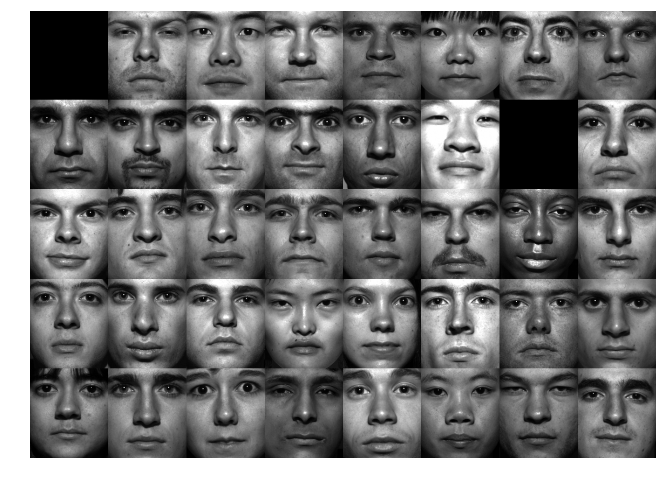

In [53]:
# Make Face Board from Data Matrix X
kk = 1
FBnr, FBnc = 5, 8
FB = np.zeros((FBnr*nr, FBnc*nc))
for jj in range(0, maxL):
    if numims[jj]>0:
        a, loc = np.where(Y == jj)
        x = X[:,loc[kk]]
        A = unpackcw(x,nr)
        row, col = divmod(jj,FBnc)
        rpt, cpt = row*nr, col*nc
        FB[rpt:rpt+nr, cpt:cpt+nc] = A
plt.figure(figsize = (15, 8))
plt.imshow(FB, cmap = 'gray')
plt.axis('off')
plt.show()

## 3.3 Preparing for PCA Projections

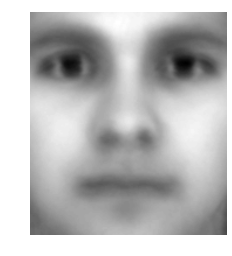

In [54]:
# 3.3.1 Calculating and Displaying Mean Image

mu = np.sum(X, axis=1)/X.shape[1]

for i in range(X.shape[1]):
    X[:,i] -= mu

avgFaceImg = unpackcw(mu,nr)
plt.figure(1)
plt.imshow(avgFaceImg, cmap = 'gray')
plt.axis('off')
plt.show()

In [7]:
## 3.3.2 Performing SVD

doSVD = 0

if doSVD == 1:
    U,S,V = np.linalg.svd(X, full_matrices=0, compute_uv=1)
    np.save('U.npy', U)
    np.save('S.npy', S)
    np.save('V.npy', V)
else:
    U = np.load('U.npy')
    S = np.load('S.npy')

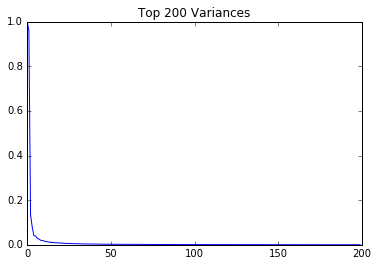

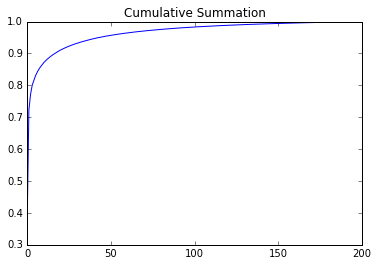

In [23]:
## 3.3.3 Displaying top 200 Variances

sigs = np.square(S[0:200]) 

plt.figure()
plt.plot(sigs /  sigs[0])
plt.title('Top 200 Variances')
plt.show()

plt.figure()
plt.plot(np.cumsum(sigs) / sum(sigs))
plt.title('Cumulative Summation')
plt.show()

In [9]:
## 3.3.4 Save Z values 

mkZ = 1

if mkZ == 1:
    for d in [2,4,8,16,32,64,128,256,512]:
        Ud = U[:,0:d]
        Z = np.dot(Ud.T, X)
        name = 'Z'+str(d)
        np.save(name, Z)

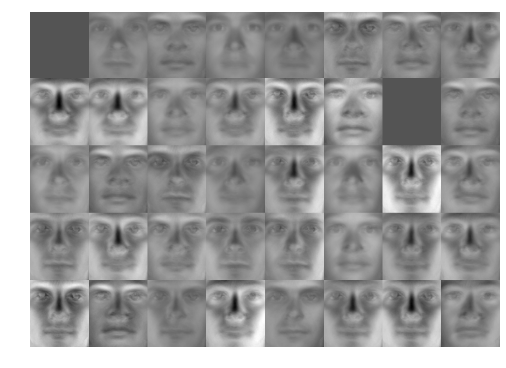

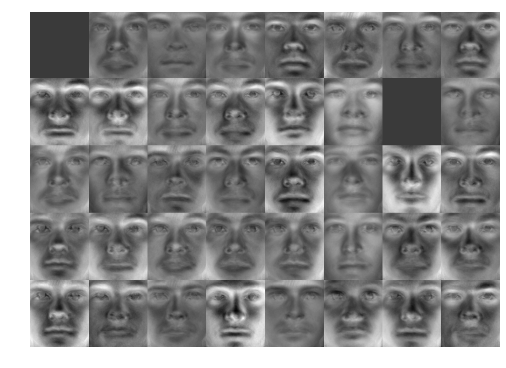

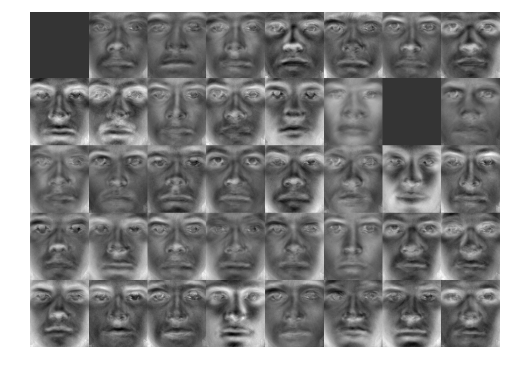

In [10]:
## 3.3.5 Make Face Board from Approximate Images

kk = 1
FBnr, FBnc = 5, 8
for d in [8, 16, 32]:
    # load Z
    name = 'Z'+str(d)+'.npy'
    Z = np.load(name)
    Ud = U[:,0:d]

    X_approx = np.dot(Ud, Z)
    
    FB = np.zeros((FBnr*nr, FBnc*nc))
    for jj in range(0, maxL):
        if numims[jj]>0:
            a, loc = np.where(Y == jj)
            x = X_approx[:,loc[kk]]
            A = unpackcw(x,nr)
            row, col = divmod(jj,FBnc)
            rpt, cpt = row*nr, col*nc
            FB[rpt:rpt+nr, cpt:cpt+nc] = A
    plt.figure(figsize = (16, 6))
    plt.imshow(FB, cmap = 'gray')
    plt.axis('off')
    plt.show()
    

## 4.1 First Set of Experiments

In [11]:
## 4.1.1 Generate Training / Testing Datasets with Labels

def splitData(group1, group2, d):
    # load Z
    name = 'Z'+str(d)+'.npy'
    Z = np.load(name)

    d_train = [] #np.array((d, (len(group1) + len(group2)) * 40 ))
    d_test = [] #np.array((d, (len(group1) + len(group2)) * 40 ))

    label_train = []
    label_test = []

    for jj in group1: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(Z[:,idx])
                    label_train.append(0)
                else:
                    d_test.append(Z[:,idx])
                    label_test.append(0)        

    for jj in group2: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(Z[:,idx])
                    label_train.append(1)
                else:
                    d_test.append(Z[:,idx])
                    label_test.append(1)

    d_train = np.array(d_train)
    d_test = np.array(d_test)

    label_train = np.array(label_train)
    label_test = np.array(label_test)
    
    return d_train, d_test, label_train, label_test


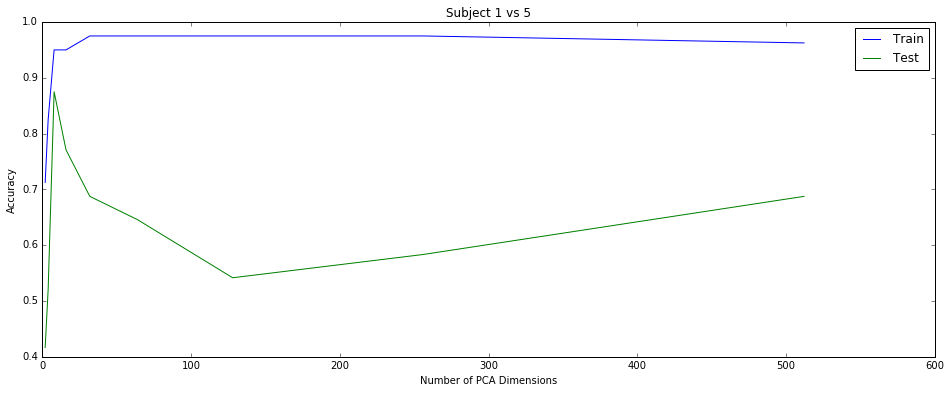

In [33]:
## 4.1.2 Training an SVM, experimenting with C

def plotAccuracyAcrossD(group1, group2, title, kernel='rbf', c=1, splitFunc=splitData):
    acc_train = []
    acc_test = []
    dlist = [2, 4, 8, 16, 32, 64, 128, 256, 512]
    for d in dlist:
        d_train, d_test, label_train, label_test = splitFunc(group1, group2, d)

        scaler_train = preprocessing.StandardScaler().fit(d_train)
        d_trainst = scaler_train.transform(d_train)

        scaler_test = preprocessing.StandardScaler().fit(d_test)
        d_testst = scaler_test.transform(d_test)

        svc = SVC(C=c, kernel=kernel)
        svc.fit(d_trainst, label_train)

        acc_train.append( svc.score(d_trainst, label_train) )
        acc_test.append( svc.score(d_testst, label_test) )

    plt.figure(figsize = (16, 6))
    plt.plot(dlist, acc_train)
    plt.plot(dlist, acc_test)
    plt.title(title)
    plt.xlabel('Number of PCA Dimensions')
    plt.ylabel('Accuracy')
    plt.legend(labels=['Train', 'Test'])
    plt.show()
    
plotAccuracyAcrossD([1],[5], "Subject 1 vs 5")

Training accuracy rapidly approaches 1 as the number of dimensions increases. However, overfitting occurs, and the testing accuracy decreases after d = 16, and slowly improves as the number of dimensions increases again. 


For subject 1 vs 5, Training accuracy becomes very high and approaches 1 as C increases. Test accuracy plummets at higher C values. At lower C values (0.1), testing accuracy is more stable across d. At very low C values (0.01), the testing accuracy becomes erratic. Similar results were seen when comparing subjects 1 and 2, and 32 and 34. 

Choosing a good C value depends on the d value chosen for PCA. We see a spike in testing accuracy around d = 16, followed by a dip and a gradual increase for a constant value of C. We use testing accuracy as a metric rather than training accuracy because it is more indicative of actual performance. 

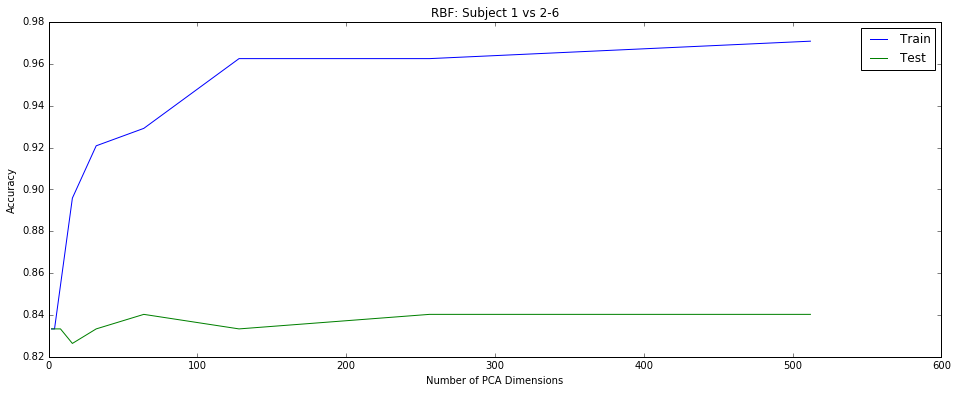

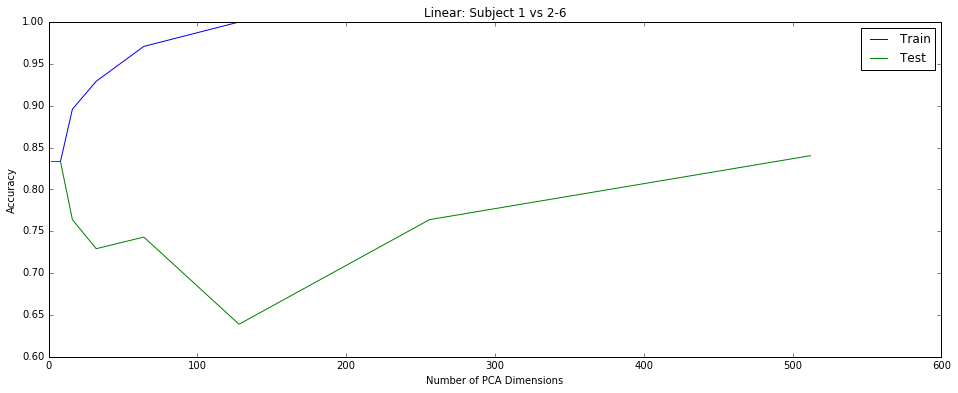

In [27]:
## 4.1.3 Binary Classification, Experiments using Different Kernels

g1 = [1]
g2 = [2,3,4,5,6]

plotAccuracyAcrossD(g1, g2, 'RBF: Subject 1 vs 2-6')
plotAccuracyAcrossD(g1, g2, 'Linear: Subject 1 vs 2-6', kernel='linear')

When comparing subjects 1 and 2 through 6 using a linear kernel, we see an early spike at d = 16, followed by a dip and gradual increase back to the original spike maximum as d increases. At extremely low C values (C < 0.001) the testing acurracy is stable across all d at an accuracy of 85%. In general, past the initial dip, higher d values yield higher testing accuracy. Training accuracy decreases for low C values, possibly because overfitting is avoided. 

For the RBF kernel, the values are much more stable at higher C values over all d. This means the training accuracy is also higher. At low C values, the testing accuracy is essentially a flat line at ~85%. In general, the stabilized testing accuracy is comparable to that of the linear kernel, but the RBF kernel maintains stability at higher C values.

## 4.2 Second Set of Experiments

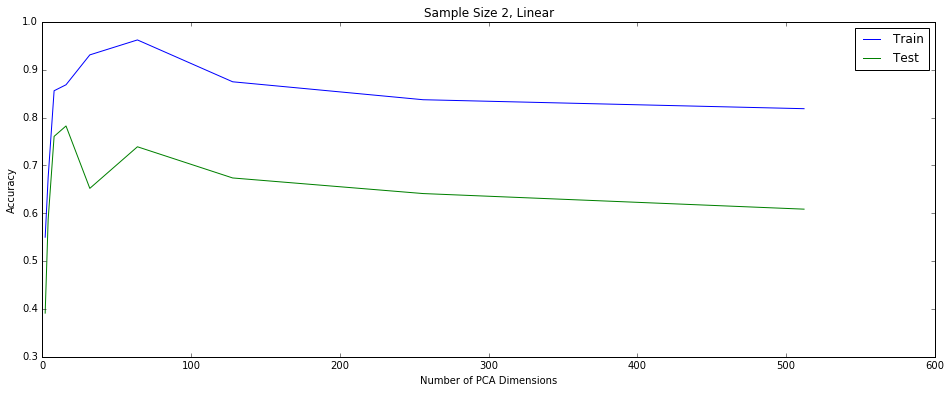

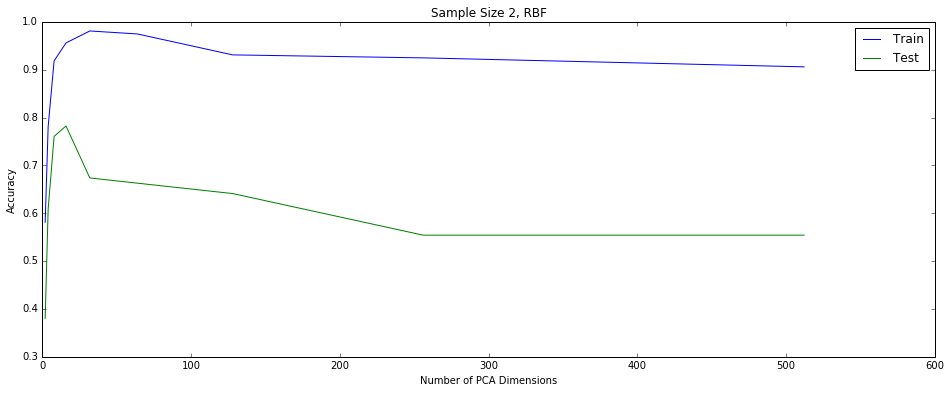

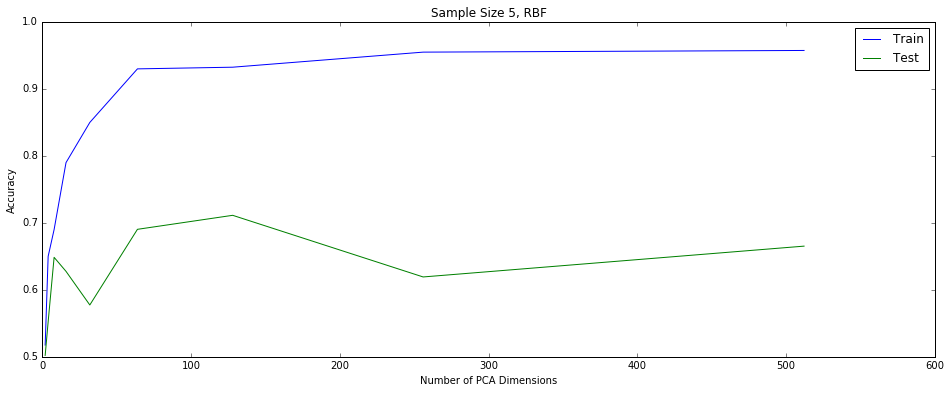

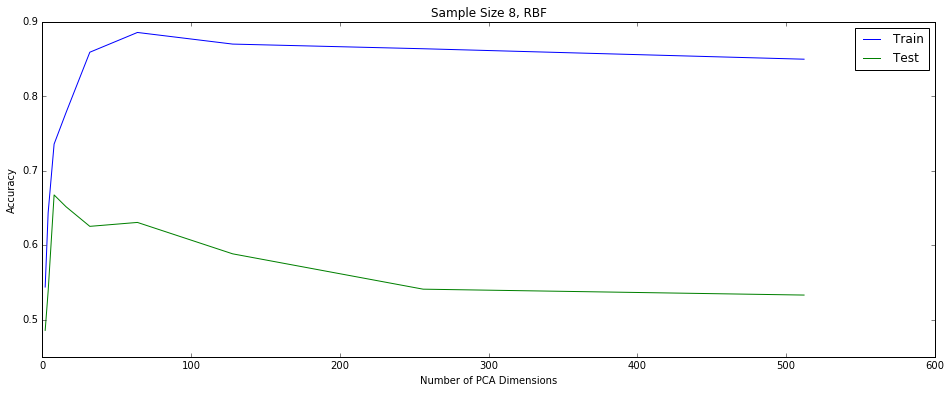

In [31]:
### 4.2.1 Binary Classification of Male vs Female faces 

dlist = [2, 4, 8, 16, 32, 64, 128, 256, 512]


group1 = [[9, 11],[9, 11],[1, 2, 8, 9, 10],[1, 2, 8, 9, 10, 11, 19, 39]]
group2 = [[5, 32],[5, 32],[5, 15, 24, 27, 28],[5, 15, 24, 27, 28, 32, 34, 37]]
titles = ['Sample Size 2, Linear', 'Sample Size 2, RBF', 'Sample Size 5, RBF', 'Sample Size 8, RBF']
kernels = ['linear', 'rbf', 'rbf', 'rbf']

for i in range(4):
    plotAccuracyAcrossD(group1[i], group2[i], titles[i], kernel=kernels[i], c=0.00001)

In our experiments, we altered the following 5 factors that were in our control:

1) Dif Kernel (Linear vs. RBF)

2) C value

3) Number of dimensions (d value)

4) Sample Size

5) Sample Selection


Firstly, we saw that the RBF kernel performs much better than the linear kernel for a sample size of 1 and 5, but for a sample size of 8 (8 men and 8 women), the linear actually outperforms RBF. #####RATIONALE#####

Secondly, we observe that, independent of the sample size, kernel type and d, an extremely low C value (~0) makes the SVM perform much better than higher C values like 1 or 50.

Thirdly, we see that the maximum accuracy always occurs for low d$\approx$8 values independent of the other factors.

Fourthly, we see that the maximum accuracy decreases as the number of men and women in the different groups (sample size) increases. This makes sense since adding more samples increases the variability within the two groups, whereas just comparing 1 or 2 men to 1 or 2 women allows the SVM to be more specific to the faces of the particular samples and perform better.

Fifthly, we see that if we intentionally choose samples that have distinctive male and female characteristics (men = unibrow and facial hair, women=hair bangs), then the SVM does perform much better in terms of accuracy for all d.

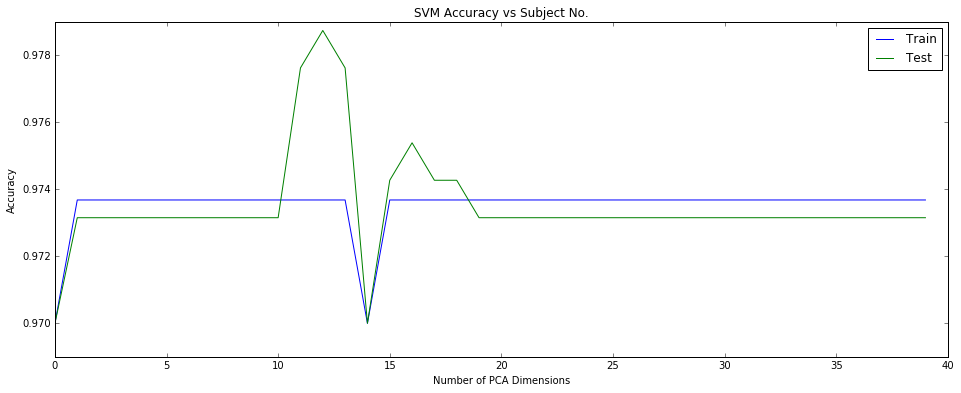

In [18]:
## 4.2.2 Multi-Class (One vs Rest) Classification

def listGenerator(unique):
    list1 = [unique]
    list2 = range(40)
    list2.remove(unique)
    list2.remove(0)
    list2.remove(14)
    return list1, list2

d = 2

acc_train = []
acc_test = []
for index in range(40):
    if index == 0 or index == 14:
        acc_train.append(0.97)
        acc_test.append(0.97)
        continue
    
    list1, list2 = listGenerator(index)
    d_train, d_test, label_train, label_test = splitData(list1,list2, d)

    scaler_train = preprocessing.StandardScaler().fit(d_train)
    d_trainst = scaler_train.transform(d_train)

    scaler_test = preprocessing.StandardScaler().fit(d_test)
    d_testst = scaler_test.transform(d_test)

    svc = LinearSVC(C=0.00001)
    svc.fit(d_trainst, label_train)

    acc_train.append( svc.score(d_trainst, label_train) )
    acc_test.append( svc.score(d_testst, label_test) )

plt.figure(figsize = (16, 6))
plt.plot(range(40), acc_train)
plt.plot(range(40), acc_test)
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy vs Subject No.')
plt.legend(labels=['Train', 'Test'])
plt.show()

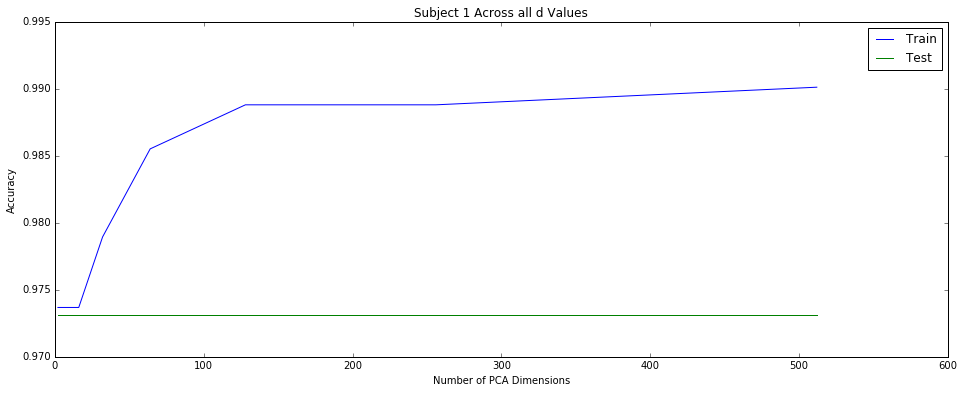

In [32]:
g1 = [1]
g2 = range(2,40)

plotAccuracyAcrossD(g1, g2, 'Subject 1 Across all d Values')

The latter of the two plots show that testing performance does not vary for the individual across different d values, when the groups are one-vs-rest. As such, the d value for the first plot can be chosen arbitrarily.

We see the highest uniqueness among the subjetcs 11, 12 and 13, which make sense visually. Subject 11 has a distinctive unibrow, subject 12 has a large nose, and subject 13 looks very white in the photo. Thus it makes sense why they are considered the most unique. We did not process subjects 0 and 14, since they were black boxes in the faceboard. That is why they both drop sharply to the same value. 

In [19]:
## 4.2.3 Using Subsamples instead of PCA Projection

def splitDataSubsample(group1, group2, rate):

    d_train = [] 
    d_test = [] 

    label_train = []
    label_test = []
    
    pixels = []
    for i in range(192):
        for j in range(168):
            if i % rate == 0 and j % rate == 0:
                pixels.append(i*168 + j)                
    
    for jj in group1: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(X[pixels,idx])
                    label_train.append(0)
                else:
                    d_test.append(X[pixels,idx])
                    label_test.append(0)        

    for jj in group2: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(X[pixels,idx])
                    label_train.append(1)
                else:
                    d_test.append(X[pixels,idx])
                    label_test.append(1)

    d_train = np.array(d_train)
    d_test = np.array(d_test)

    label_train = np.array(label_train)
    label_test = np.array(label_test)
    
    return d_train.astype('float64'), d_test.astype('float64'), label_train, label_test

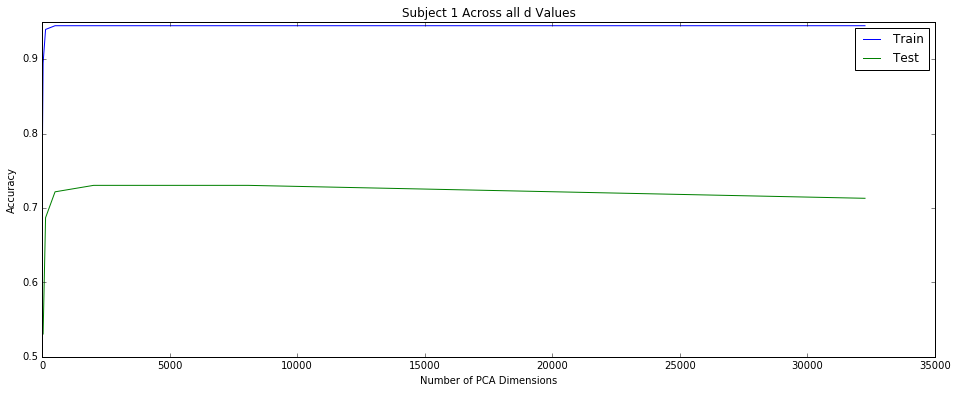

In [20]:
acc_train = []
acc_test = []
rates = [1,2,4,8,16,32,64,128,256,512]
imgsize = []

for rate in rates:
    d_train, d_test, label_train, label_test = splitDataSubsample([12, 32],[5, 27, 37], rate)
    
    imgsize.append(d_train.shape[1])
    scaler_train = preprocessing.StandardScaler().fit(d_train)
    d_trainst = scaler_train.transform(d_train)

    scaler_test = preprocessing.StandardScaler().fit(d_test)
    d_testst = scaler_test.transform(d_test)

    svc = SVC(C=1, kernel='rbf')
    svc.fit(d_trainst, label_train)

    acc_train.append( svc.score(d_trainst, label_train) )
    acc_test.append( svc.score(d_testst, label_test) )
    
plt.figure(figsize = (16, 6))
plt.plot(imgsize, acc_train)
plt.plot(imgsize, acc_test)
plt.xlabel('Number of PCA Dimensions')
plt.ylabel('Accuracy')
plt.title('Subject 1 Across all d Values')
plt.legend(labels=['Train', 'Test'])
plt.show()

## 4.3 Open Ended Experiments

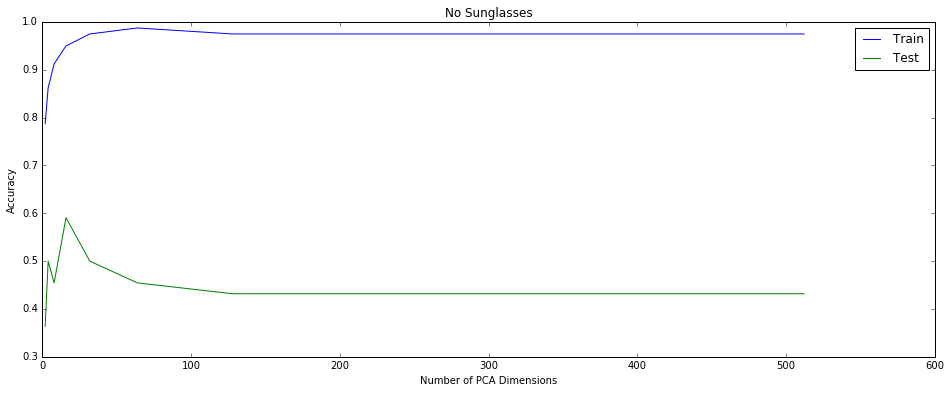

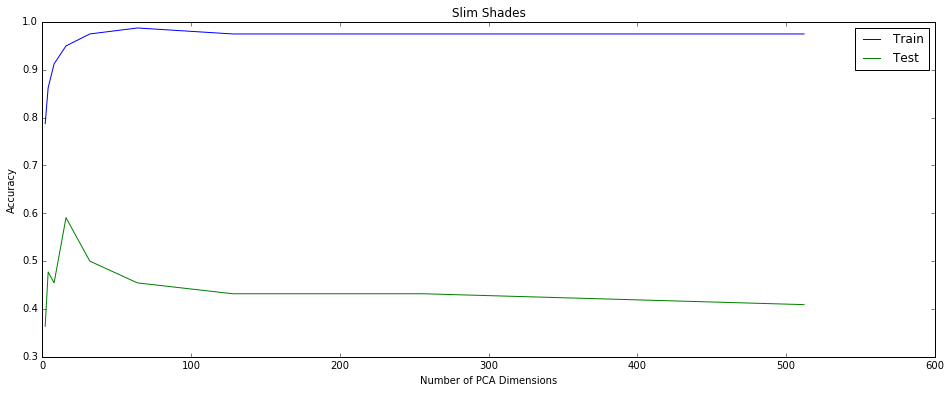

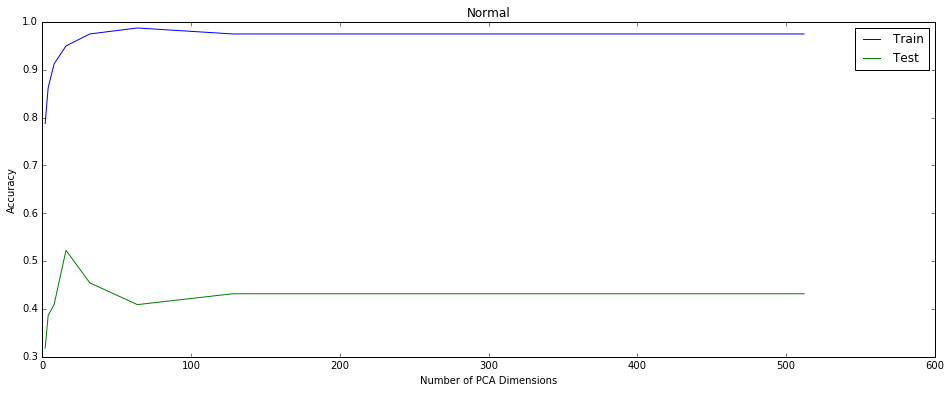

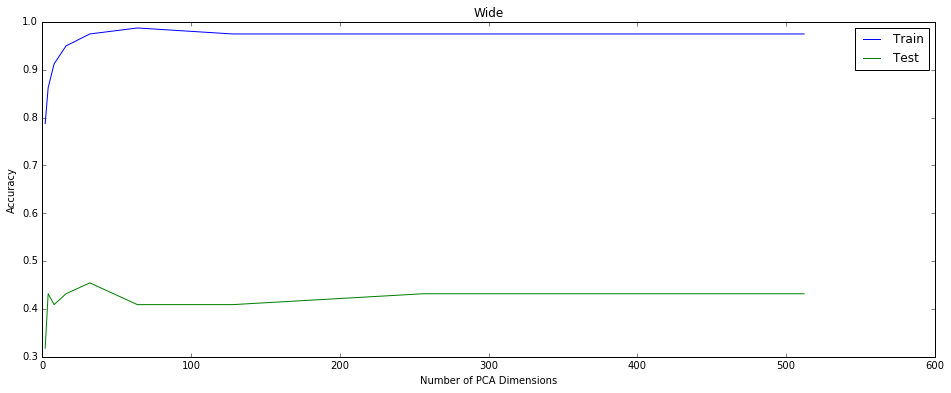

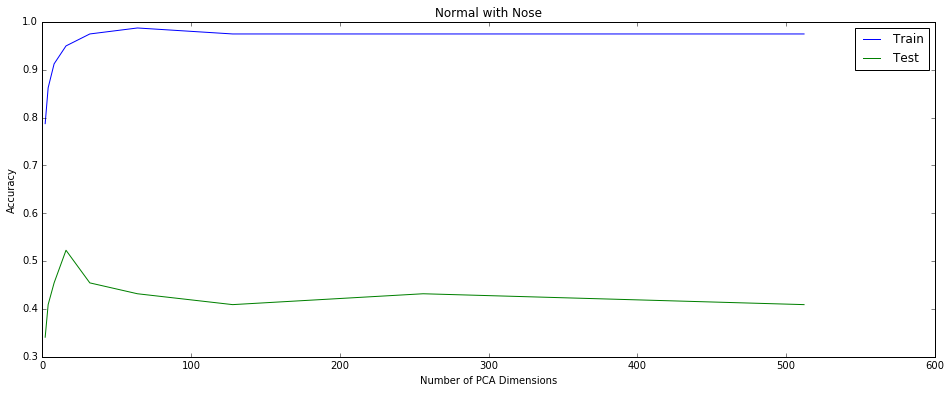

In [266]:
## 4.3.1 Performance After Obscuring with Sunglasses

def addSunglasses(img_vec, glasses, nose):
    img = unpackcw(img_vec,nr)
    for r, row in enumerate(img):
        for c, px in enumerate(row):
            if r in glasses and c not in nose:
                img[r,c]=0 


def splitDataSunglasses(group1, group2, d):
    # load Z
    name = 'Z'+str(d)+'.npy'
    Z = np.load(name)
    Ud = U[:,0:d]

    X_approx = np.dot(Ud, Z)
    
    mask = np.ones(mu.shape)
    addSunglasses(mask, w, n)
    X_sg = (X_approx.T * mask).T

    d_train = [] 
    d_test = [] 

    label_train = []
    label_test = []

    for jj in group1: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(X_approx[:,idx])
                    label_train.append(0)
                else:
                    d_test.append(X_sg[:,idx])
                    label_test.append(0)        

    for jj in group2: 
        if numims[jj]>0:
            a, loc = np.where(Y == jj)

            for i, idx in enumerate(loc):
                if i < 40:
                    d_train.append(X_approx[:,idx])
                    label_train.append(1)
                else:
                    d_test.append(X_sg[:,idx])
                    label_test.append(1)

    d_train = np.array(d_train)
    d_test = np.array(d_test)

    label_train = np.array(label_train)
    label_test = np.array(label_test)
    
    return d_train, d_test, label_train, label_test

g1 = [13]
g2 = [39]

titles = ['No Sunglasses', 'Slim Shades', 'Normal', 'Wide', 'Normal with Nose']
widths = [[], range(35,55),range(30,70),range(20,80),range(30,70)]
noses = [[],[],[],[],range(70,100)]

for i in range(5):
    w = widths[i]
    n = noses[i]
    
    outimg = mu.copy()
    addSunglasses(outimg, w, n)
    plt.figure(1)
    plt.imshow(unpackcw(outimg,nr), cmap = 'gray')
    plt.axis('off')
    plt.show()
    
    outimg = addSunglasses(mu.copy(), w, n)
    
    
    plotAccuracyAcrossD(g1, g2, titles[i], splitFunc=splitDataSunglasses)


Analyzing results of adding on sunglasses

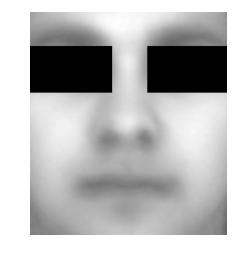

In [268]:
outimg = mu.copy()
addSunglasses(outimg, w, n)
outimg = unpackcw(outimg,nr)
plt.figure(1)
plt.imshow(outimg, cmap = 'gray')
plt.axis('off')
plt.show()

In [113]:
                
def addVerticalOcclusion(img_vec, vertwidth):
    img = unpackcw(img_vec,nr)
    for r, row in enumerate(img):
        for c, px in enumerate(row):
            if c in vertwidth:
                img[r,c]=0

# outimg = mu.copy()        
# addSunglasses(outimg, slim, nose)
# img = unpackcw(outimg,nr)
# plt.figure()
# plt.imshow(img, cmap = 'gray')
# plt.axis('off')
# plt.show()

IndentationError: expected an indented block (<ipython-input-113-daadd1b30c33>, line 7)

In [115]:
# Copyright 2015 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Functions for downloading and reading MNIST data."""
from __future__ import absolute_import
from __future__ import division

import gzip
import tempfile
from tensorflow.contrib.learn.python.learn.datasets import base


from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

In [117]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [248]:
class DataSet(object):

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
#       assert images.shape[3] == 1
#       images = images.reshape(images.shape[0],
#                               images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(np.float32)
        images = np.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)
      ]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = np.arange(self._num_examples)
      np.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]

In [247]:
trainlen = 40
validlen = 50
testlen = 58

d_train = [] #np.array((d, (len(group1) + len(group2)) * 40 ))
d_test = [] #np.array((32256, 38*10))
d_valid = []

label_train = []
label_test = []
label_valid = []

subjnum = 0
for jj in range(3):
    if numims[jj]>0:
        subjnum += 1
        a, loc = np.where(Y == jj)
        subject_imgs = np.array(X[:,loc])
        d_train += subject_imgs[:,:trainlen].T.tolist()
        d_valid += subject_imgs[:,trainlen:validlen].T.tolist()
        d_test  += subject_imgs[:,validlen:testlen].T.tolist()
        label_train += [jj]*trainlen
        label_valid += [jj]*(validlen-trainlen)
        label_test += [jj]*(testlen - validlen)
        
d_train = np.array(d_train)
d_test = np.array(d_test)
d_valid = np.array(d_valid)

numSubjects = len(numims)
label_train = np.eye(numSubjects)[label_train]
label_valid = np.eye(numSubjects)[label_valid]
label_test = np.eye(numSubjects)[label_test]

# build dataset
Datasets = collections.namedtuple('Datasets', ['train', 'validation', 'test'])

dtype='uint32'
train = DataSet(d_train, label_train)
valid = DataSet(d_valid, label_valid)
test  = DataSet(d_test, label_test)

yaleb = Datasets(train=train, validation=valid, test=test)


In [229]:
# init variables
imglen = 32256
x = tf.placeholder(tf.float32, [None, imglen])

W = tf.Variable(tf.zeros([imglen, numSubjects]))
b = tf.Variable(tf.zeros([numSubjects]))
y = tf.nn.softmax(tf.matmul(x, W) + b)

# set up training
y_ = tf.placeholder(tf.float32, [None, numSubjects])
cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

# begin session
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)

# train
for i in range(1000):
    batch_xs, batch_ys = yaleb.train.next_batch(50)
    sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

# check accuracy
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(sess.run(accuracy, feed_dict={x: yaleb.test.images, y_: yaleb.test.labels}))


(80, 40)
(80, 32256)


In [262]:
"""Functions for downloading and reading MNIST data."""
# Copyright 2015 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import gzip

import numpy
from six.moves import xrange  # pylint: disable=redefined-builtin

from tensorflow.contrib.learn.python.learn.datasets import base
from tensorflow.python.framework import dtypes
from tensorflow.python.platform import gfile

SOURCE_URL = 'http://yann.lecun.com/exdb/mnist/'


def _read32(bytestream):
  dt = numpy.dtype(numpy.uint32).newbyteorder('>')
  return numpy.frombuffer(bytestream.read(4), dtype=dt)[0]


def extract_images(filename):
  """Extract the images into a 4D uint8 numpy array [index, y, x, depth]."""
  print('Extracting', filename)
  with gfile.Open(filename, 'rb') as f, gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2051:
      raise ValueError('Invalid magic number %d in MNIST image file: %s' %
                       (magic, filename))
    num_images = _read32(bytestream)
    rows = _read32(bytestream)
    cols = _read32(bytestream)
    buf = bytestream.read(rows * cols * num_images)
    data = numpy.frombuffer(buf, dtype=numpy.uint8)
    data = data.reshape(num_images, rows, cols, 1)
    return data


def dense_to_one_hot(labels_dense, num_classes):
  """Convert class labels from scalars to one-hot vectors."""
  num_labels = labels_dense.shape[0]
  index_offset = numpy.arange(num_labels) * num_classes
  labels_one_hot = numpy.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot


def extract_labels(filename, one_hot=False, num_classes=10):
  """Extract the labels into a 1D uint8 numpy array [index]."""
  print('Extracting', filename)
  with gfile.Open(filename, 'rb') as f, gzip.GzipFile(fileobj=f) as bytestream:
    magic = _read32(bytestream)
    if magic != 2049:
      raise ValueError('Invalid magic number %d in MNIST label file: %s' %
                       (magic, filename))
    num_items = _read32(bytestream)
    buf = bytestream.read(num_items)
    labels = numpy.frombuffer(buf, dtype=numpy.uint8)
    if one_hot:
      return dense_to_one_hot(labels, num_classes)
    return labels


class DataSet(object):

  def __init__(self,
               images,
               labels,
               fake_data=False,
               one_hot=False,
               dtype=dtypes.float32):
    """Construct a DataSet.
    one_hot arg is used only if fake_data is true.  `dtype` can be either
    `uint8` to leave the input as `[0, 255]`, or `float32` to rescale into
    `[0, 1]`.
    """
    dtype = dtypes.as_dtype(dtype).base_dtype
    if dtype not in (dtypes.uint8, dtypes.float32):
      raise TypeError('Invalid image dtype %r, expected uint8 or float32' %
                      dtype)
    if fake_data:
      self._num_examples = 10000
      self.one_hot = one_hot
    else:
      assert images.shape[0] == labels.shape[0], (
          'images.shape: %s labels.shape: %s' % (images.shape, labels.shape))
      self._num_examples = images.shape[0]

      # Convert shape from [num examples, rows, columns, depth]
      # to [num examples, rows*columns] (assuming depth == 1)
      assert images.shape[3] == 1
      images = images.reshape(images.shape[0],
                              images.shape[1] * images.shape[2])
      if dtype == dtypes.float32:
        # Convert from [0, 255] -> [0.0, 1.0].
        images = images.astype(numpy.float32)
        images = numpy.multiply(images, 1.0 / 255.0)
    self._images = images
    self._labels = labels
    self._epochs_completed = 0
    self._index_in_epoch = 0

  @property
  def images(self):
    return self._images

  @property
  def labels(self):
    return self._labels

  @property
  def num_examples(self):
    return self._num_examples

  @property
  def epochs_completed(self):
    return self._epochs_completed

  def next_batch(self, batch_size, fake_data=False):
    """Return the next `batch_size` examples from this data set."""
    if fake_data:
      fake_image = [1] * 784
      if self.one_hot:
        fake_label = [1] + [0] * 9
      else:
        fake_label = 0
      return [fake_image for _ in xrange(batch_size)], [
          fake_label for _ in xrange(batch_size)
      ]
    start = self._index_in_epoch
    self._index_in_epoch += batch_size
    if self._index_in_epoch > self._num_examples:
      # Finished epoch
      self._epochs_completed += 1
      # Shuffle the data
      perm = numpy.arange(self._num_examples)
      numpy.random.shuffle(perm)
      self._images = self._images[perm]
      self._labels = self._labels[perm]
      # Start next epoch
      start = 0
      self._index_in_epoch = batch_size
      assert batch_size <= self._num_examples
    end = self._index_in_epoch
    return self._images[start:end], self._labels[start:end]


def read_data_sets(train_dir,
                   fake_data=False,
                   one_hot=False,
                   dtype=dtypes.float32):
    if fake_data:

        def fake():
            return DataSet([], [], fake_data=True, one_hot=one_hot, dtype=dtype)

        train = fake()
        validation = fake()
        test = fake()
        return base.Datasets(train=train, validation=validation, test=test)

    TRAIN_IMAGES = 'train-images-idx3-ubyte.gz'
    TRAIN_LABELS = 'train-labels-idx1-ubyte.gz'
    TEST_IMAGES = 't10k-images-idx3-ubyte.gz'
    TEST_LABELS = 't10k-labels-idx1-ubyte.gz'
    VALIDATION_SIZE = 5000

    local_file = base.maybe_download(TRAIN_IMAGES, train_dir,
                                   SOURCE_URL + TRAIN_IMAGES)
    train_images = extract_images(local_file)

    local_file = base.maybe_download(TRAIN_LABELS, train_dir,
                                   SOURCE_URL + TRAIN_LABELS)
    train_labels = extract_labels(local_file, one_hot=one_hot)

    local_file = base.maybe_download(TEST_IMAGES, train_dir,
                                   SOURCE_URL + TEST_IMAGES)
    test_images = extract_images(local_file)

    local_file = base.maybe_download(TEST_LABELS, train_dir,
                                   SOURCE_URL + TEST_LABELS)
    test_labels = extract_labels(local_file, one_hot=one_hot)
    
    print (test_labels.shape)

    validation_images = train_images[:VALIDATION_SIZE]
    validation_labels = train_labels[:VALIDATION_SIZE]
    train_images = train_images[VALIDATION_SIZE:]
    train_labels = train_labels[VALIDATION_SIZE:]

    train = DataSet(train_images, train_labels, dtype=dtype)
    validation = DataSet(validation_images, validation_labels, dtype=dtype)
    test = DataSet(test_images, test_labels, dtype=dtype)

    return Datasets(train=train, validation=validation, test=test)


def load_mnist():
  return read_data_sets('MNIST_data')

In [263]:
load_mnist()

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
(10000,)


Datasets(train=<__main__.DataSet object at 0x114d90b90>, validation=<__main__.DataSet object at 0x115c8c890>, test=<__main__.DataSet object at 0x1160cc650>)

In [265]:
test_labels

NameError: name 'test_labels' is not defined